# Лабораторная работа 2: Искусственный нейрон и перцептрон 

 ## 1. Импорт библиотек и константы

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Константы
SIZE = 100
SEED = 42
EPOCHS = 100
LEARNING_RATE = 0.01

# Фиксируем seed для воспроизводимости
np.random.seed(SEED)

## 2. Реализация функций активации (Задание 1)

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    f = sigmoid(x)
    return f * (1 - f)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x > 0, 1, 0)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, x * alpha)

def leaky_relu_deriv(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_deriv(x, alpha=1.0):
    return np.where(x > 0, 1, elu(x, alpha) + alpha)


# Словарь для удобного доступа к функциям по имени
ACTIVATIONS = {
    'sigmoid': (sigmoid, sigmoid_deriv),
    'tanh': (tanh, tanh_deriv),
    'relu': (relu, relu_deriv),
    'leaky_relu': (leaky_relu, leaky_relu_deriv),
    'elu': (elu, elu_deriv)
}

## 3. Функции обучения и предсказания

In [8]:
def predict(X, weights, bias, act_func):
    """
    Вычисляет выход нейрона: y = f(w*x + b)
    """
    linear_output = np.dot(X, weights) + bias
    return act_func(linear_output)

def train_perceptron(X, y, activation_name, epochs=EPOCHS, lr=LEARNING_RATE):
    """
    Основная функция обучения.
    Инициализирует веса и обновляет их по правилу градиентного спуска.
    """
    # Получаем нужную функцию активации и её производную
    if activation_name not in ACTIVATIONS:
        raise ValueError(f"Неизвестная функция: {activation_name}")
    
    act_func, act_deriv = ACTIVATIONS[activation_name]
    
    # Инициализация весов (случайная) и смещения (ноль)
    n_features = X.shape[1]
    weights = np.random.randn(n_features)
    bias = 0.0
    
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            # 1. Прямой проход (Forward pass)
            linear_out = np.dot(X[i], weights) + bias
            y_pred = act_func(linear_out)
            
            # 2. Вычисление ошибки
            error = y[i] - y_pred
            
            # 3. Вычисление градиента
            # grad = (y_true - y_pred) * f'(z)
            grad = error * act_deriv(linear_out)
            
            # 4. Обновление весов (Backward pass)
            weights += lr * grad * X[i]
            bias += lr * grad
            
            epoch_loss += error ** 2
            
        loss_history.append(epoch_loss / len(X))
        
    return weights, bias, loss_history

## 4. Генерация данных и эксперименты (Задание 2)

Обучение с функцией: sigmoid...
Обучение с функцией: tanh...
Обучение с функцией: relu...
Обучение с функцией: leaky_relu...
Обучение с функцией: elu...


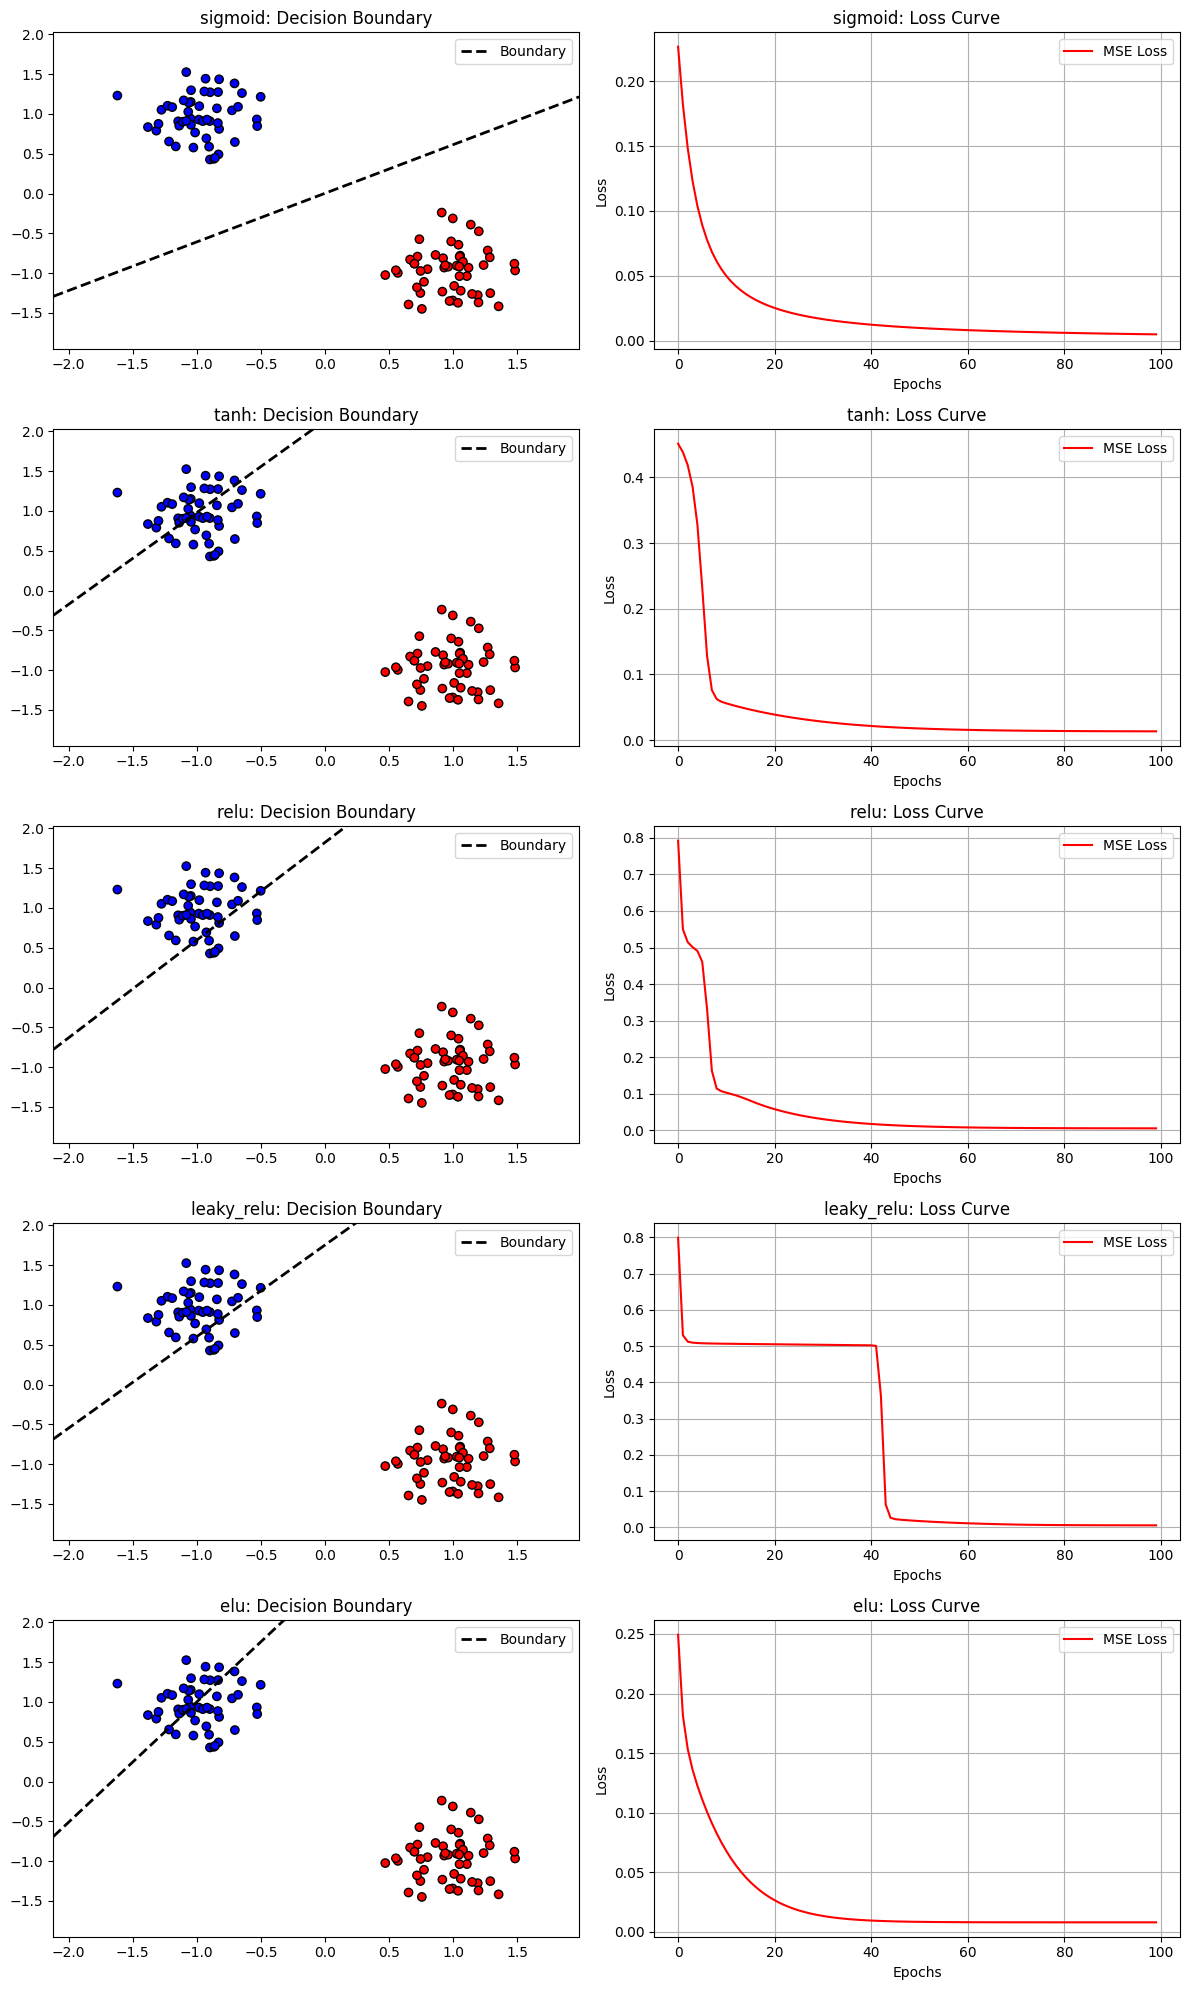

In [11]:
X, y = make_blobs(n_samples=SIZE, centers=2, n_features=2, random_state=SEED)

# Нормализация данных
X = (X - X.mean(axis=0)) / X.std(axis=0)

activation_list = ['sigmoid', 'tanh', 'relu', 'leaky_relu', 'elu']

# Увеличиваем высоту фигуры пропорционально количеству функций
n_acts = len(activation_list)
plt.figure(figsize=(12, 4 * n_acts))

for idx, act_name in enumerate(activation_list):
    print(f"Обучение с функцией: {act_name}...")
    
    # Обучаем модель (получаем обученные веса)
    weights, bias, losses = train_perceptron(X, y, act_name, epochs=EPOCHS, lr=LEARNING_RATE)
    
    # --- Левый график: Граница решения ---
    plt.subplot(n_acts, 2, 2 * idx + 1)
    plt.title(f"{act_name}: Decision Boundary")
    
    # Точки
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
    
    # Разделяющая прямая: y = -(bias + w0*x) / w1
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    if weights[1] != 0:
        x_vals = np.array([x_min, x_max])
        y_vals = -(bias + weights[0] * x_vals) / weights[1]
        plt.plot(x_vals, y_vals, 'k--', lw=2, label='Boundary')
    
    plt.xlim(x_min, x_max)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    plt.legend()

    # --- Правый график: Функция потерь ---
    plt.subplot(n_acts, 2, 2 * idx + 2)
    plt.plot(losses, label='MSE Loss', color='red')
    plt.title(f"{act_name}: Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## 5. Ответы на вопросы (Задание 3)

# <small>
#
# **1. Что делает функция активации в искусственном нейроне?**
# - Функция активации принимает взвешенную сумму входов ($z = \sum w_i x_i + b$) и преобразует её в выходной сигнал нейрона. Она добавляет в модель **нелинейность**, что позволяет нейронным сетям разделять сложные данные и аппроксимировать любые функции. Без неё нейронная сеть, независимо от количества слоёв, была бы эквивалентна обычной линейной регрессии.
#
# **2. Чем отличается искусственный нейрон от однослойного перцептрона?**
# - **Искусственный нейрон** — это структурная единица (математическая модель), вычисляющая взвешенную сумму и применяющая функцию активации.
# - **Однослойный перцептрон** — это архитектура нейронной сети, состоящая из одного (или нескольких независимых) искусственных нейронов, работающих параллельно и подключенных непосредственно к входам. Часто термины используют как синонимы, когда говорят о модели с одним выходом.
#
# **3. Какое правило используется для обучения перцептрона?**
# - Используется **правило дельты (Delta Rule)** или обобщенное правило обучения перцептрона (метод градиентного спуска). Веса обновляются пропорционально ошибке и входному сигналу:
# $$ w_{new} = w_{old} + \eta \cdot (y_{true} - y_{pred}) \cdot f'(z) \cdot x $$
# Где $\eta$ — скорость обучения, а $f'(z)$ — производная функции активации (необходима для непрерывных функций вроде сигмоиды).
#
# **4. Почему однослойный перцептрон не может решить задачу XOR?**
# - Задача XOR («Исключающее ИЛИ») не является **линейно разделимой**. Однослойный перцептрон строит линейную границу (прямую линию на плоскости), но невозможно провести одну прямую так, чтобы отделить точки $(0,0)$ и $(1,1)$ от точек $(0,1)$ и $(1,0)$. Эту проблему описали Минский и Пейперт, показав необходимость скрытых слоёв.
#
# **5. Что произойдет, если изменить функцию активации с сигмоиды на ReLU?**
# - **Изменится диапазон выхода:** Сигмоида выдает значения $(0, 1)$, а ReLU — $[0, \infty)$.
# - **Ускорится обучение:** У ReLU нет экспоненциальных вычислений, а производная в положительной области равна 1, что решает проблему затухания градиента (которая есть у сигмоиды при больших входах).
# - **Появится риск «мёртвых нейронов»:** Если взвешенная сумма станет отрицательной, градиент ReLU станет 0, и нейрон перестанет обучаться (веса перестанут обновляться).
#
# </small>